# 1. 라이브러리 불러오기

In [191]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# pandas 열 개수 max 설정
pd.set_option('display.max_columns', 100)
# pandas 행 개수 max 설정
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 로딩 및 추가 처리

In [5]:
# 분석 개요 -> 데이터 설명 -> 전처리 -> 통계 분석 -> 시각화
# 연체 고객 중에서도 개입이 필요한 고객, 그 이유
df_grouped = pd.read_csv(r'.\data\Bank Data Grouped.csv')
# ================================================================================
# 추가적인 데이터 전처리
# ---<Monthly Balance 변수 정제>---
# 음수 값 개수 확인 및 제거
negative_balance = df_grouped[df_grouped['Monthly_Balance'] < 0]
print("음수 값 개수 :", negative_balance.shape[0])

# 음수 값 제거
df_grouped = df_grouped[df_grouped['Monthly_Balance'] >= 0]

# ---<Interest Rate 변수 정제>---
# 100 이상인 값 확인
high_interest_rate = df_grouped[df_grouped['Interest_Rate'] >= 100]
print("100 이상인 값 개수 :", high_interest_rate.shape[0])

# 100 이상인 값 제거
df_grouped = df_grouped[df_grouped['Interest_Rate'] < 100]

# reset_index
df_grouped.reset_index(drop=True, inplace=True)

음수 값 개수 : 6
100 이상인 값 개수 : 1


In [288]:
df_grouped[['Credit_Mix', 'Age']].groupby('Credit_Mix').mean()

Age
Credit_Mix           
Bad         30.344639
Good        37.409889
Standard    33.444641

# 3. 파생 변수 생성
- 연령대 변수
- 월 소득 대비 EMI 
- 월 소득 대비 투자 비용
- 월 소득 대비 미결재 부채 비율 (Outstanding_Debt)

## 3-1. 연령대 변수 (Age_group) 생성

In [159]:
## <Age_group 변수 생성> ##
# ================================================================================
# Age별 Credit_Mix 비율
df_grouped['Age_group'] = pd.cut(df_grouped['Age'], bins=[0, 18, 30, 40, 50, 60, 100], labels=['10s', '20s', '30s', '40s', '50s', 'over 60s'])

## 3-2. 월 소득 대비 EMI 변수 "EMI_to_Income_Ratio"

In [162]:
df_grouped['EMI_to_Income_Ratio'] = df_grouped['Total_EMI_per_month'] / df_grouped['Monthly_Inhand_Salary']

## 3-3. 월 소득 대비 투자 비율 변수 "Investment_to_Income_Ratio"

In [163]:
df_grouped['Investment_to_Income_Ratio'] = df_grouped['Amount_invested_monthly'] / df_grouped['Monthly_Inhand_Salary']

## 3-4. 월 소득 대비 미결재부채 (대략 몇 개월동안 갚아야 하는지)

In [166]:
df_grouped['Outstanding_Debt_to_Income_Ratio'] = df_grouped['Outstanding_Debt'] / df_grouped['Monthly_Inhand_Salary']

In [168]:
# df_grouped.to_csv(r'.\data\Bank Data Grouped(revised_1).csv', index=False)

### 3-1-1. 연령대 그룹 별 신용 상태 확인

In [167]:

age_credit_mix = df_grouped.groupby(['Age_group', 'Credit_Mix']).size().unstack().fillna(0)

# 총합 계산 (행과 열)
age_credit_mix['Total'] = age_credit_mix.sum(axis=1)
age_credit_mix.loc['Total'] = age_credit_mix.sum()

# 결과 출력
age_credit_mix

Credit_Mix   Bad  Good  Standard  Total
Age_group                              
10s          370     9       432    811
20s         1099  1181      1969   4249
30s          945   952      1639   3536
40s          504   975      1217   2696
50s            0   584       387    971
over 60s       1     0         1      2
Total       2919  3701      5645  12265

# 4. EDA

## 4-1. 통계 분석 기반으로 연속형 변수 중 중요한 변수 정렬하고 상위 5개 (top 5) 에 대한 설명

### 4-1-2. Anova 분석

In [170]:
import scipy.stats as stats

# Identify continuous variables
continuous_vars = df_grouped.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remove non-relevant continuous variables if necessary (e.g., Customer_ID)
if 'Customer_ID' in continuous_vars:
    continuous_vars.remove('Customer_ID')

# Prepare a dictionary to store ANOVA results
anova_results = {}

# Perform ANOVA for each continuous variable with respect to 'Credit_Mix'
for var in continuous_vars:
    groups = [group[var].dropna().values for name, group in df_grouped.groupby('Credit_Mix')]
    f_val, p_val = stats.f_oneway(*groups)
    anova_results[var] = p_val

# Sort variables based on p-values
sorted_anova_results = sorted(anova_results.items(), key=lambda x: x[1])

# Select top 5 variables
top_5_variables = sorted_anova_results[:10]

top_5_variables

[('Annual_Income', 0.0),
 ('Monthly_Inhand_Salary', 0.0),
 ('Num_Bank_Accounts', 0.0),
 ('Num_Credit_Card', 0.0),
 ('Interest_Rate', 0.0),
 ('Num_of_Loan', 0.0),
 ('Delay_from_due_date', 0.0),
 ('Num_of_Delayed_Payment', 0.0),
 ('Changed_Credit_Limit', 0.0),
 ('Num_Credit_Inquiries', 0.0)]

In [300]:
# 연체 일수가 30일 이상 , Credit_Mix 가 standard, bad 인 고객
condition = (df_grouped['Delay_from_due_date'] >= 25) & (df_grouped['Delay_from_due_date'] < 30) & ((df_grouped['Credit_Mix'] == 'standard') | (df_grouped['Credit_Mix'] == 'Bad'))
df_grouped[condition].shape[0] / df_grouped.shape[0]

0.026661231145536077

In [188]:
# 연속형 변수 식별
continuous_vars = [
    'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
    'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
    'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 
    'Credit_Utilization_Ratio', 'Total_EMI_per_month'
]

# ANOVA 수행 및 효과 크기 계산
anova_results = []
for var in continuous_vars:
    groups = [group[var].dropna().values for name, group in df_grouped.groupby('Credit_Mix')]
    f_val, p_val = stats.f_oneway(*groups)
    
    # 효과 크기 계산 (Eta Squared)
    eta_squared = f_val * (len(df_grouped) - 1) / (f_val * (len(df_grouped) - 1) + len(df_grouped) - len(groups))
    anova_results.append((var, f_val, p_val, eta_squared))

# p-value와 효과 크기를 기준으로 정렬
sorted_anova_results = sorted(anova_results, key=lambda x: (x[2], -x[3]))

# 상위 10개 변수 선택
top_5_variables = sorted_anova_results[:]

In [190]:
# 결과를 데이터프레임으로 변환
columns = ['Variable', 'F-Value', 'P-Value', 'Effect Size (Eta Squared)']
result_df = pd.DataFrame(top_5_variables, columns=columns)
# result_df.to_csv(r'.\data\ANOVA_Results.csv', index=False)

IndexError: index 6 is out of bounds for axis 0 with size 6

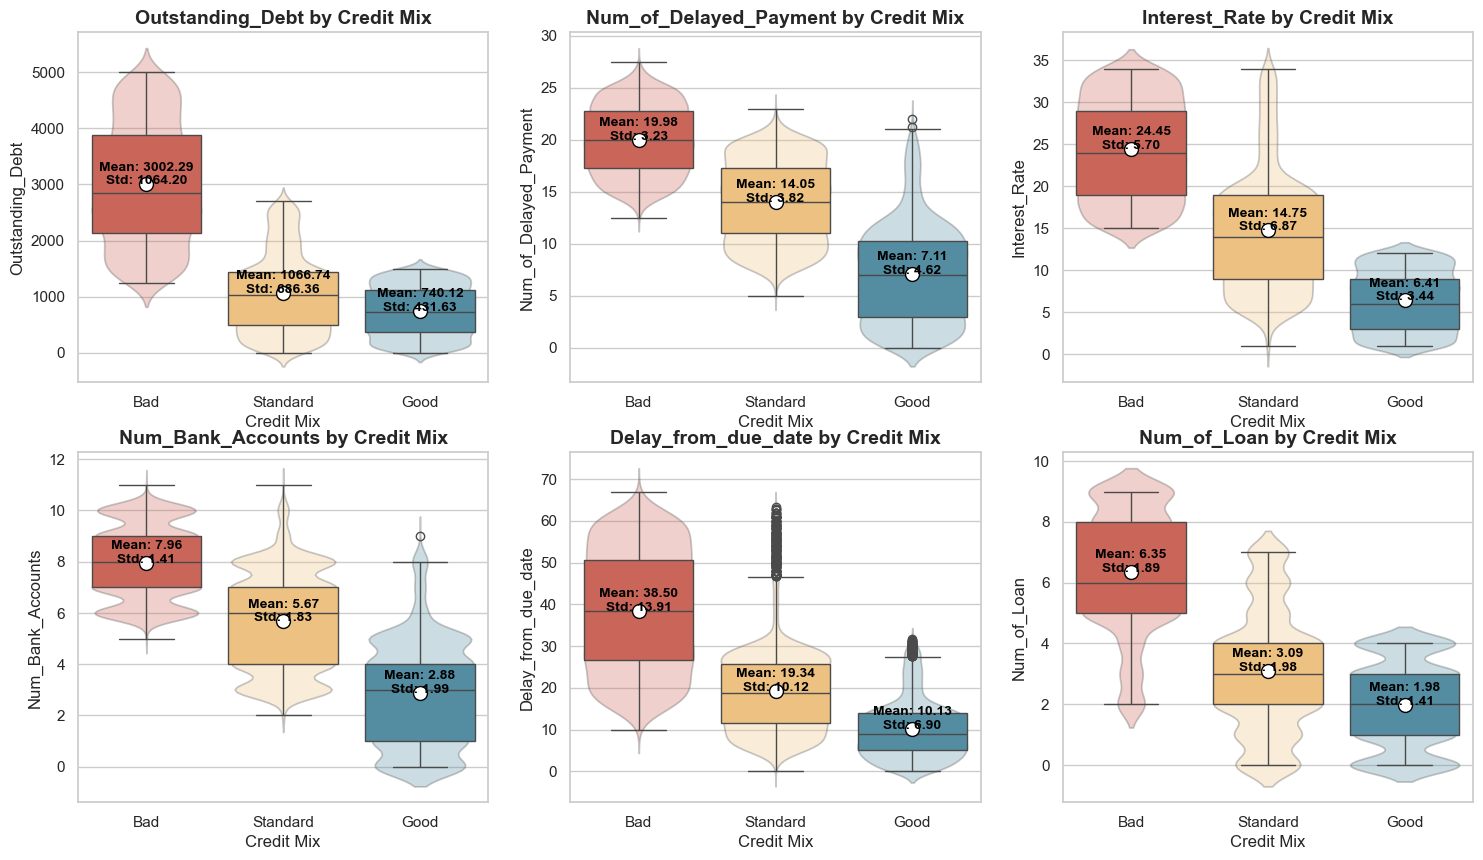

In [237]:
# Color palette for Credit_Mix categories
palette = {'Bad': '#DD5746', 'Standard': '#FFC470', 'Good': '#4793AF'}

# 서브플롯 함수
def plot_stylish_box_violin(var, ax):
    sns.boxplot(x='Credit_Mix', y=var, data=df_grouped, ax=ax, palette=palette, showmeans=True, meanprops={"marker":"o",
                        "markerfacecolor":"white", 
                        "markeredgecolor":"black",
                        "markersize":"10"})
    sns.violinplot(x='Credit_Mix', y=var, data=df_grouped, ax=ax, palette=palette, inner=None, alpha=0.3)
    ax.set_title(f'{var} by Credit Mix', fontsize=14, fontweight='bold')
    ax.set_xlabel('Credit Mix', fontsize=12)
    ax.set_ylabel(var, fontsize=12)
    for i in range(len(df_grouped['Credit_Mix'].unique())):
        mean = df_grouped[df_grouped['Credit_Mix'] == df_grouped['Credit_Mix'].unique()[i]][var].mean()
        std = df_grouped[df_grouped['Credit_Mix'] == df_grouped['Credit_Mix'].unique()[i]][var].std()
        ax.text(i, mean, f'Mean: {mean:.2f}\nStd: {std:.2f}', horizontalalignment='center', size='small', color='black', weight='semibold')

# 서브플롯 설정
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# 상위 5개 변수 시각화
for i, var in enumerate([x[0] for x in top_5_variables]):
    plot_stylish_box_violin(var, axes[i])

# 마지막 빈 플롯 제거
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## 4-2. 연령대 vs Credit_Mix

### 4-2-0 Credit Mix 분포

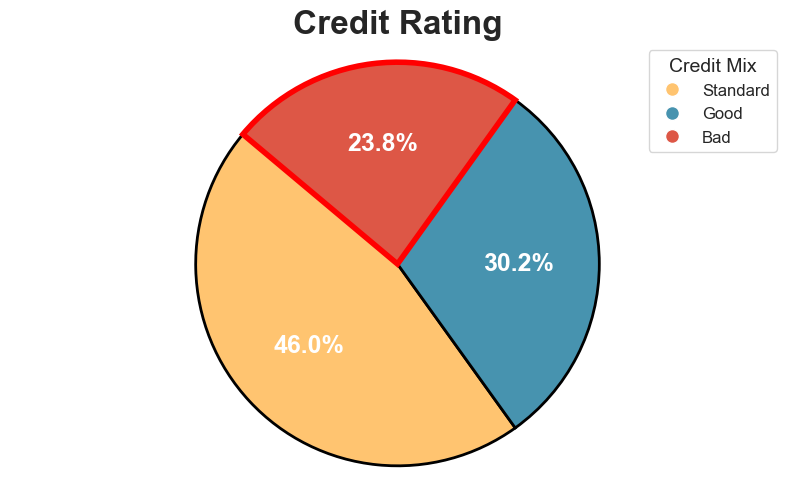

In [235]:
# 데이터 그룹화
pie_df = df_grouped['Credit_Mix'].value_counts()

# seaborn 스타일 설정
sns.set(style="whitegrid")

# 색상 설정: Standard, Good, Bad
colors = {'Standard': '#FFC470', 'Good': '#4793AF', 'Bad': '#DD5746'}

# 파이 차트 생성
plt.figure(figsize=(10, 6))
wedges, texts, autotexts = plt.pie(
    pie_df, 
    autopct='%1.1f%%', 
    colors=[colors[label] for label in pie_df.index], 
    startangle=140, 
    wedgeprops={'edgecolor': 'black', 'linewidth': 2},  # 모든 경계선 두껍게 설정
    textprops={'fontsize': 21}
)

# 텍스트를 파이 차트 내부로 설정하고, 폰트 크기 확대
for autotext in autotexts:
    autotext.set_color('white')  # 내부 텍스트 색상 변경
    autotext.set_weight('bold')  # 내부 텍스트 굵게 설정
    autotext.set_fontsize(18)  # 내부 텍스트 크기 설정

# Bad 영역 하이라이트
for i, wedge in enumerate(wedges):
    if pie_df.index[i] == 'Bad':
        wedge.set_edgecolor('red')
        wedge.set_linewidth(4)

# 범례 추가
labels = list(colors.keys())
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in labels]
plt.legend(handles, labels, loc='upper right', fontsize=12, title='Credit Mix', title_fontsize='14')

# 제목 및 스타일 설정
plt.title('Credit Rating', fontsize=24, weight='bold')
plt.ylabel('')  # y축 라벨 제거
plt.axis('equal')  # 파이 차트를 원형으로 유지

# 제목과 파이 차트 사이 간격 조정
plt.subplots_adjust(top=0.85)  # top 값을 조정하여 간격을 벌림

# 그래프 표시
plt.show()

### 4-2-1 연령대 별 Credit_Mix 분포

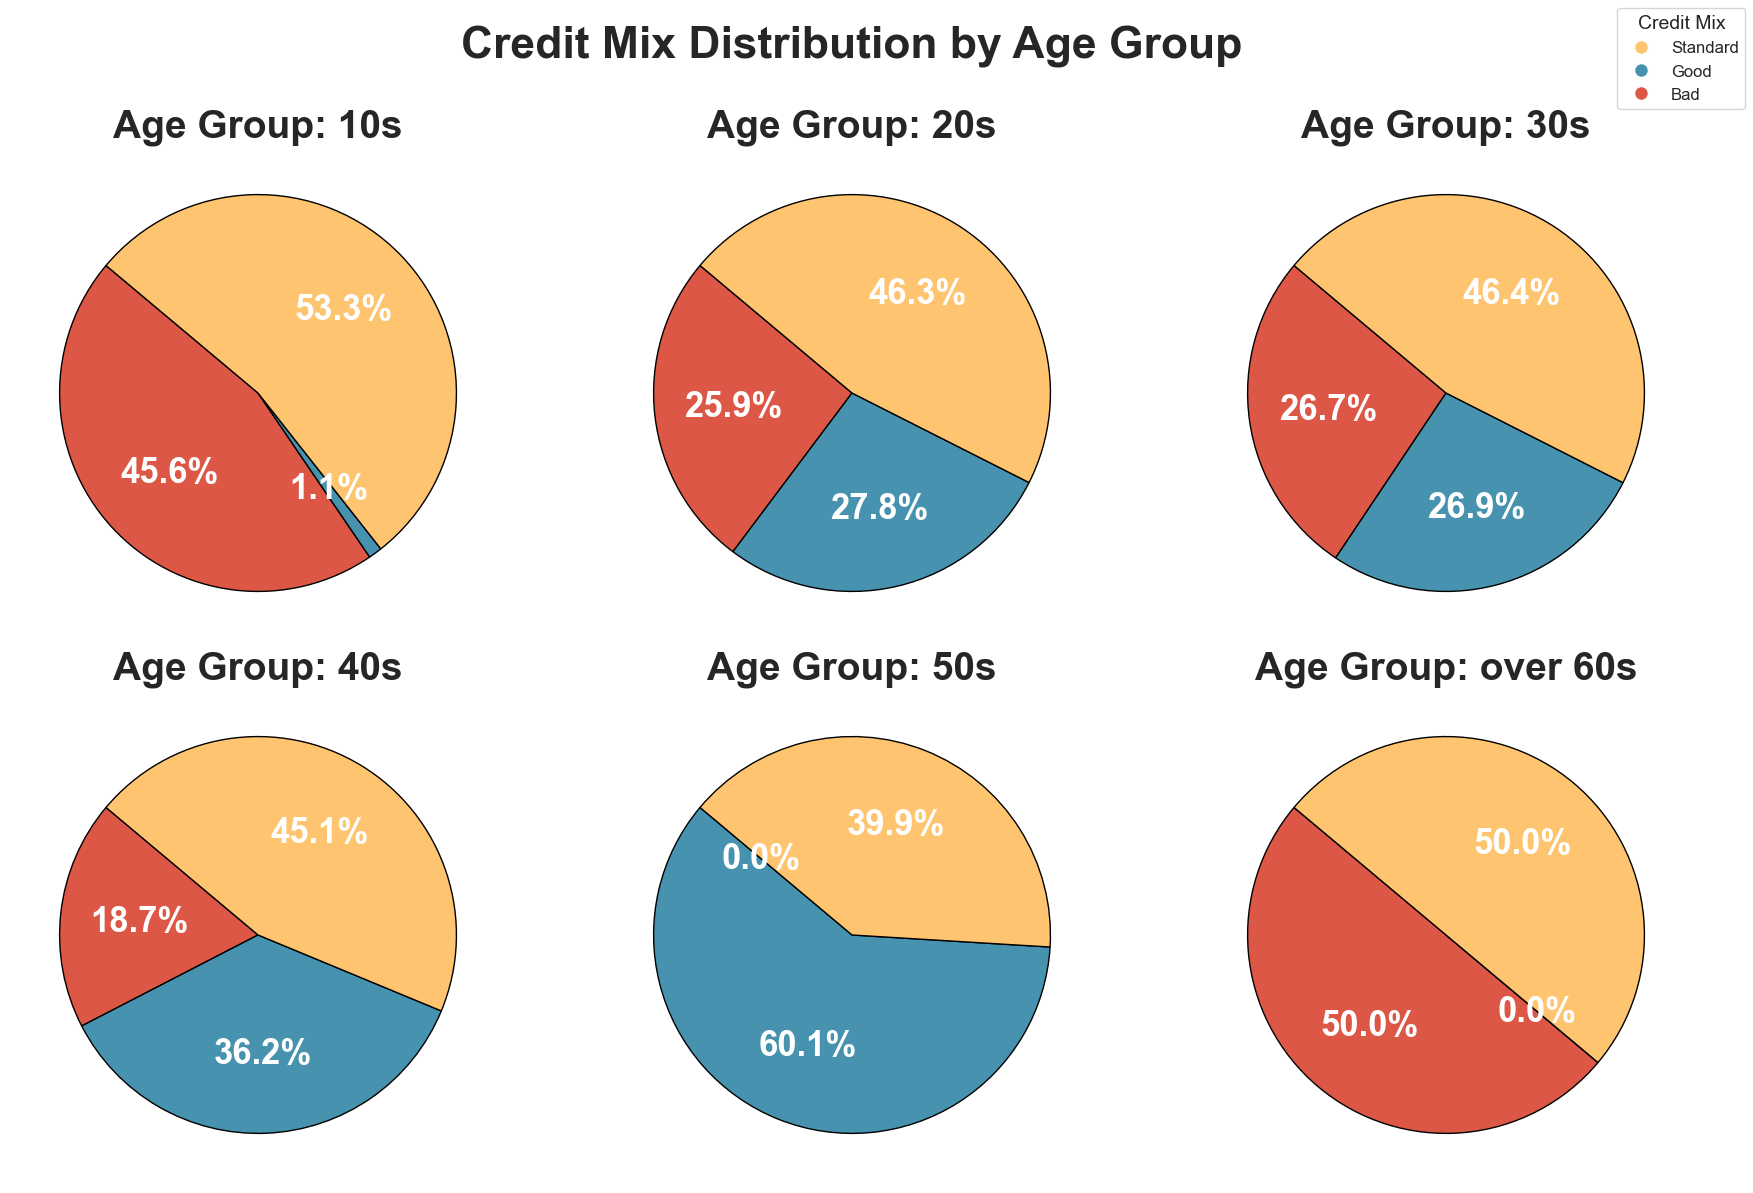

In [232]:
# 색상 설정: Standard, Good, Bad
colors = {'Standard': '#FFC470', 'Good': '#4793AF', 'Bad': '#DD5746'}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Age 그룹 목록
age_groups = age_credit_mix.index[:-1]  # 'Total' 행은 제외

for i, age_group in enumerate(age_groups):
    ax = axes[i // 3, i % 3]
    data = age_credit_mix.loc[age_group]
    
    # 색상을 Credit Mix 순서에 맞게 배열
    color_list = [colors[label] for label in data.index[:-1]]
    
    wedges, texts, autotexts = ax.pie(
        data[:-1],  # 'Total' 열은 제외
        autopct='%1.1f%%',
        colors=color_list,
        startangle=140,
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 25, 'color': 'white', 'weight': 'bold'}  # 폰트 크기 2배 조정
    )
    ax.set_title(f'Age Group: {age_group}', fontsize=28, weight='bold')  # 제목을 두 배로 키움

# 범례 추가
labels = list(colors.keys())
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in labels]
fig.legend(handles, labels, loc='upper right', fontsize=12, title='Credit Mix', title_fontsize='14')

# 제목 및 레이아웃 조정
plt.suptitle('Credit Mix Distribution by Age Group', fontsize=32, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.88)  # 제목과 그래프 사이 간격 조정

# 그래프 표시
plt.show()

In [34]:
# Age별 Credit_Mix 비율
df_grouped['Age_group'] = pd.cut(df_grouped['Age'], bins=[10, 20, 30, 40, 50, 60, 100], labels=['10s', '20s', '30s', '40s', '50s', 'over 60s'])
age_credit_mix = df_grouped.groupby(['Age_group', 'Credit_Mix']).size().unstack().fillna(0)

# 총합 계산 (행과 열)
age_credit_mix['Total'] = age_credit_mix.sum(axis=1)
age_credit_mix.loc['Total'] = age_credit_mix.sum()

# 결과 출력
age_credit_mix

Credit_Mix   Bad  Good  Standard  Total
Age_group                              
10s          565   214       733   1512
20s          904   976      1668   3548
30s          945   952      1639   3536
40s          504   975      1217   2696
50s            0   584       387    971
over 60s       1     0         1      2
Total       2919  3701      5645  12265

### 4-2-2. Credit Mix 별 Age_group 분포

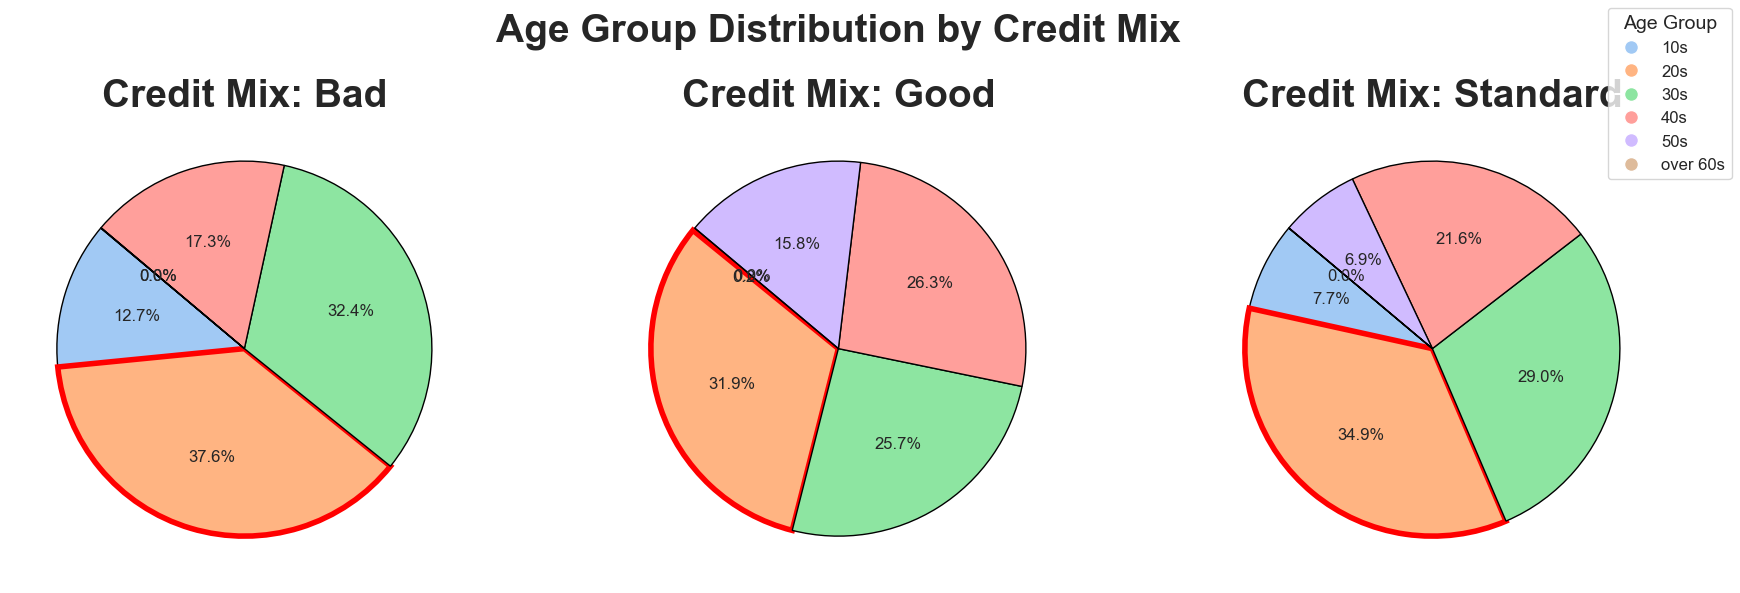

In [236]:

# Credit_Mix 별로 연령대 그룹화
credit_groups = df_grouped.groupby('Credit_Mix')['Age_group'].value_counts().unstack().fillna(0)

# 파이 차트 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (credit_mix, age_counts) in enumerate(credit_groups.iterrows()):
    wedges, texts, autotexts = axes[i].pie(
        age_counts, 
        labels=None,  # 텍스트를 제거
        autopct='%1.1f%%', 
        colors=sns.color_palette('pastel'), 
        startangle=140, 
        wedgeprops={'edgecolor': 'black'}
    )
    axes[i].set_title(f'Credit Mix: {credit_mix}', fontsize=28, weight='bold')  # 제목을 두 배로 키움

    # 가장 큰 부분을 찾고 하이라이트
    max_index = age_counts.idxmax()
    max_wedge = wedges[list(age_counts.index).index(max_index)]
    max_wedge.set_edgecolor('red')
    max_wedge.set_linewidth(4)

# 전체 제목 및 스타일 설정
plt.suptitle('Age Group Distribution by Credit Mix', fontsize=28, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 범례 추가
age_labels = age_counts.index.tolist()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in sns.color_palette('pastel', len(age_labels))]
fig.legend(handles, age_labels, loc='upper right', fontsize=12, title='Age Group', title_fontsize='14')

# 그래프 표시
plt.show()

In [48]:
# Credit_Mix 와 Payment_of_Min_Amount 변수의 관계
# 둘 다 범주형 데이터 
# 교차표 생성
payment_cross = pd.crosstab(df_grouped['Credit_Mix'], df_grouped['Payment_of_Min_Amount'])
payment_cross

Payment_of_Min_Amount    No   Yes
Credit_Mix                       
Bad                      10  2909
Good                   3701     0
Standard               1262  4383

14.0

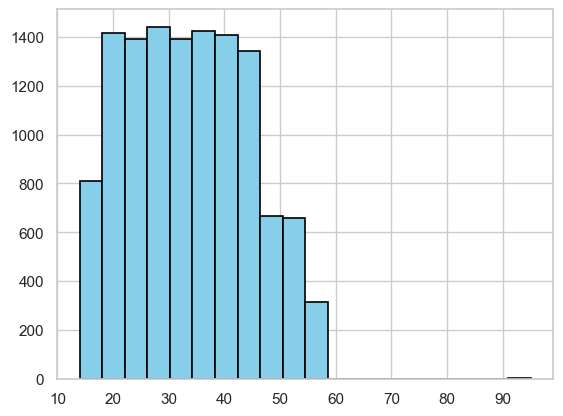

In [154]:
# Age 분포 확인
df_grouped['Age'].hist(bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
df_grouped['Age'].min()

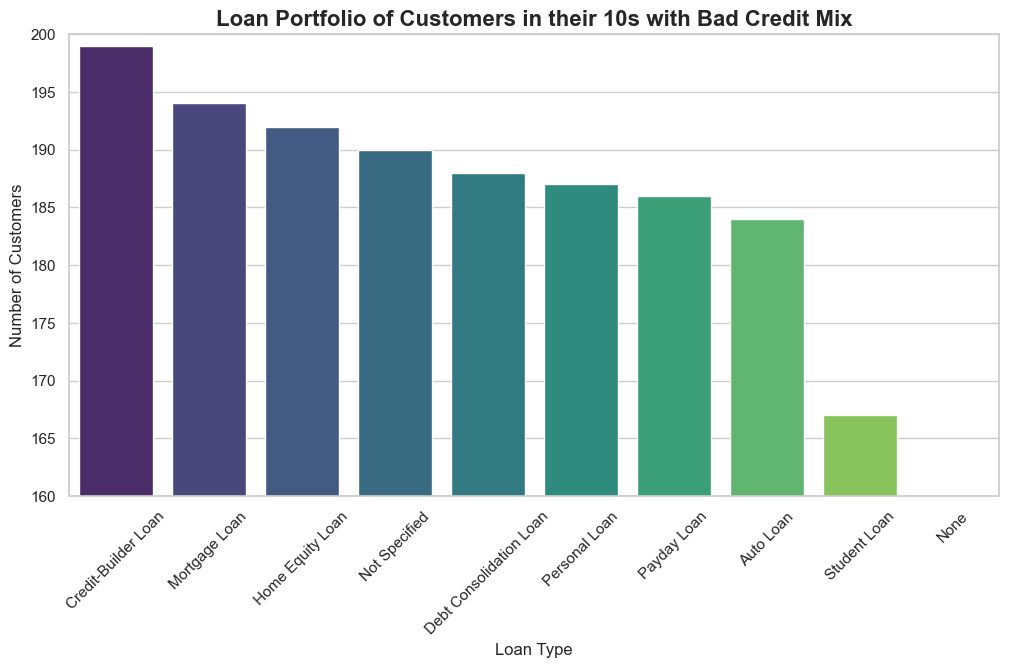

In [261]:
# 10대 
df_grouped_10 = df_grouped[(df_grouped['Age_group'] == '10s') & (df_grouped['Credit_Mix'] == 'Bad')]

# loan 변수의 분포 확인
loan_portpolio_10s = df_grouped_10[['Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'None', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan']].sum()

# 대출 변수 목록
loan_columns = [
    'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 
    'Home Equity Loan', 'Mortgage Loan', 'None', 'Not Specified', 
    'Payday Loan', 'Personal Loan', 'Student Loan'
]

# 대출 유형의 조합 분석
loan_combinations = df_grouped_10[loan_columns].sum().sort_values(ascending=False)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=loan_combinations.index, y=loan_combinations.values, palette='viridis')
plt.title('Loan Portfolio of Customers in their 10s with Bad Credit Mix', fontsize=16, weight='bold')
plt.xlabel('Loan Type', fontsize=12)
# y 간격을 10으로 설정
plt.ylim(160, 200)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
plt.show()

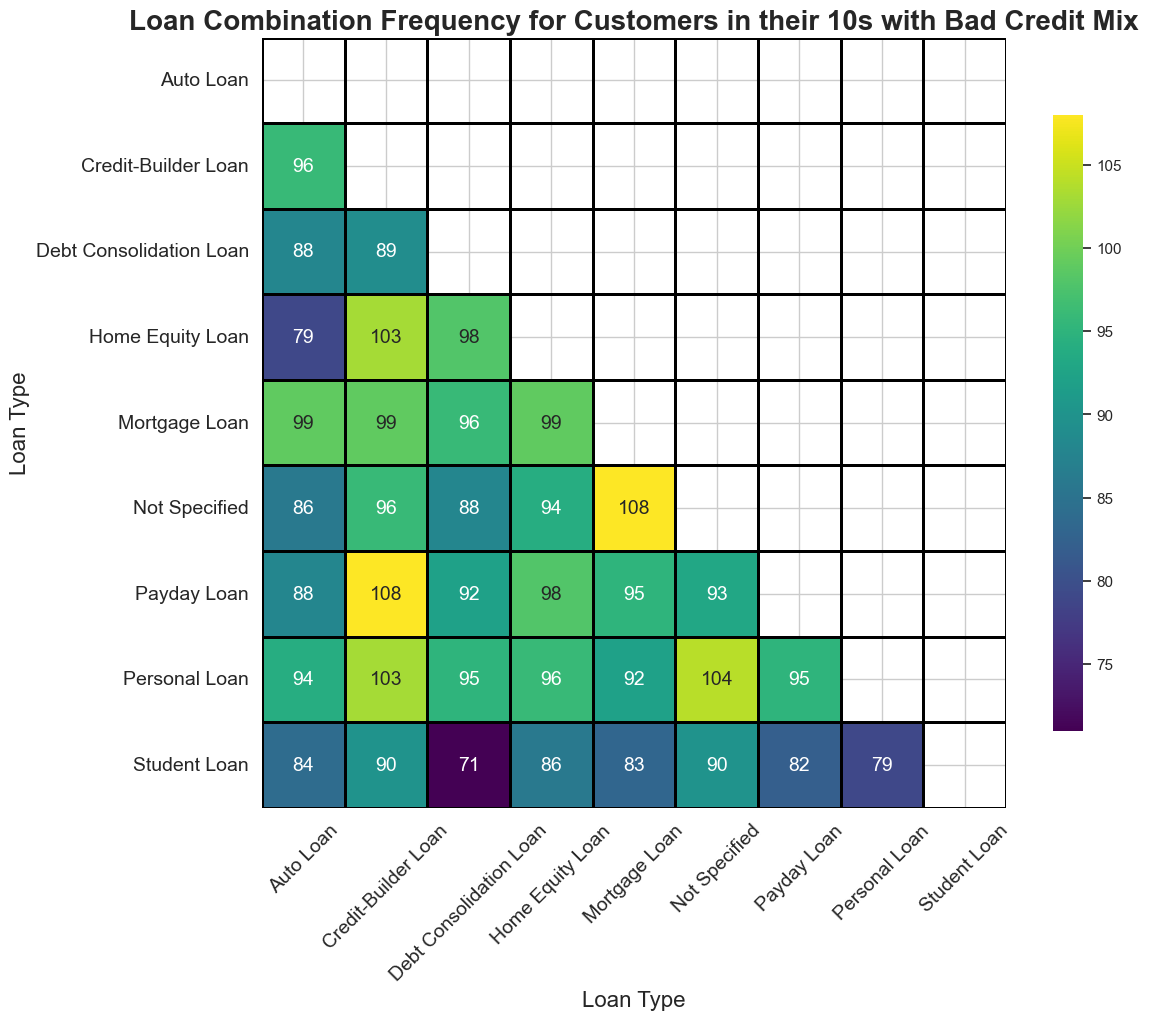

In [274]:
# 대출 유형 간 조합 빈도 분석
loan_comb_matrix = df_grouped_10[loan_columns].T.dot(df_grouped_10[loan_columns])
loan_comb_matrix = loan_comb_matrix[loan_comb_matrix.index != 'None'].drop(columns=['None'], errors='ignore')

# 대출 조합 빈도 행렬 시각화
plt.figure(figsize=(12, 10))

# 대각행렬을 기준으로 한쪽만 표시
mask = np.triu(np.ones_like(loan_comb_matrix, dtype=bool))

# 히트맵 시각화
sns.heatmap(
    loan_comb_matrix, annot=True, fmt='d', cmap='viridis', mask=mask,
    cbar_kws={"shrink": .8}, annot_kws={"size": 14}, linewidths=1, linecolor='black'
)

# 글자 크기 설정
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# 제목 및 라벨 설정
plt.title('Loan Combination Frequency for Customers in their 10s with Bad Credit Mix', fontsize=20, weight='bold')
plt.xlabel('Loan Type', fontsize=16)
plt.ylabel('Loan Type', fontsize=16)

# 그래프 표시
plt.show()

### 4-2-3. Credit Mix 별 Outstanding Debt (미지불 채무)

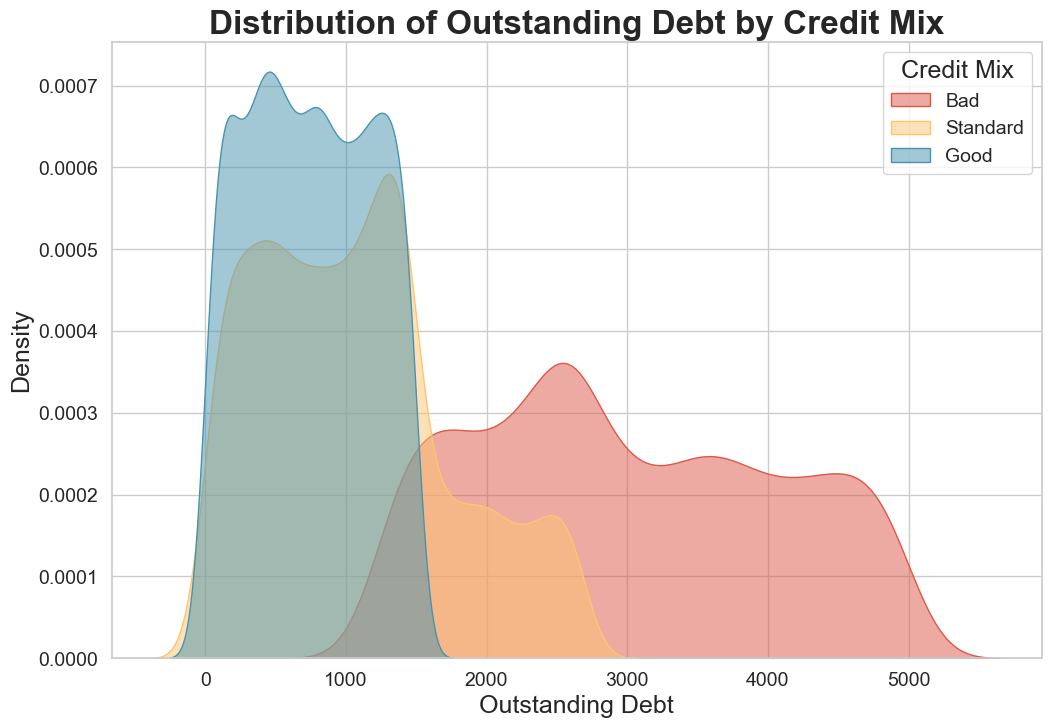

In [276]:
# 'Outstanding_Debt'에 대한 dist plot 생성
plt.figure(figsize=(12, 8))

# Credit_Mix 별로 분포 그리기
credit_mix_categories = df_grouped['Credit_Mix'].unique()
colors = {'Bad': '#DD5746', 'Standard': '#FFC470', 'Good': '#4793AF'}

for credit_mix in credit_mix_categories:
    sns.kdeplot(
        df_grouped[df_grouped['Credit_Mix'] == credit_mix]['Outstanding_Debt'], 
        label=credit_mix, 
        color=colors[credit_mix], 
        fill=True, 
        alpha=0.5
    )

# 폰트 크기 설정
plt.title('Distribution of Outstanding Debt by Credit Mix', fontsize=24, weight='bold')
plt.xlabel('Outstanding Debt', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 범례 추가
plt.legend(title='Credit Mix', title_fontsize=18, fontsize=14)

# 그래프 표시
plt.show()

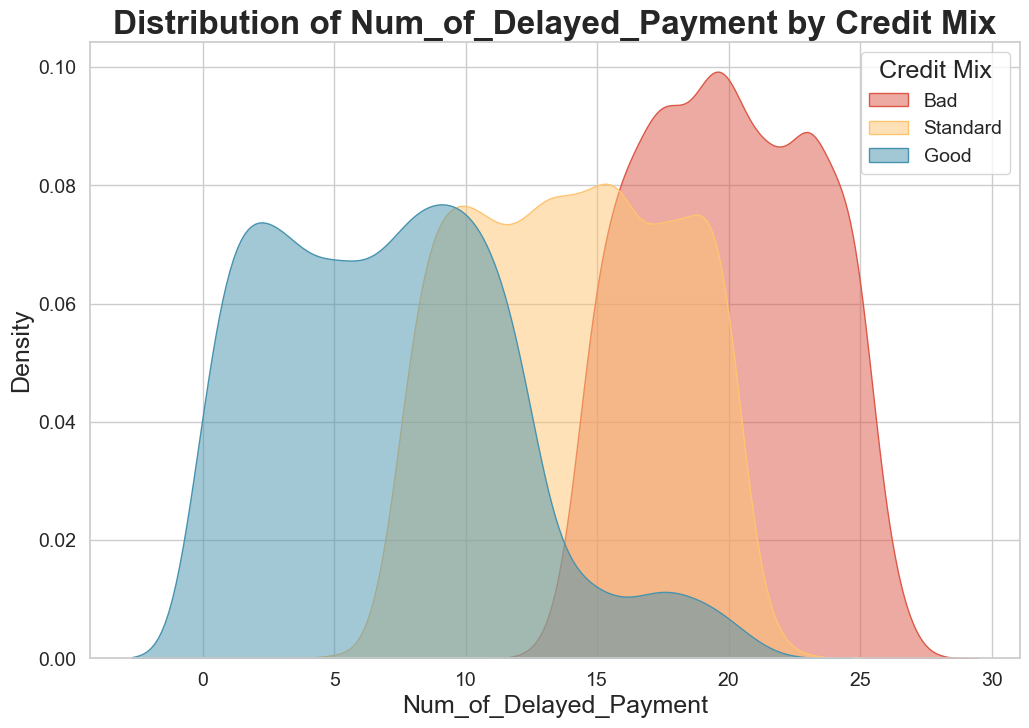

In [285]:
plt.figure(figsize=(12, 8))

# Credit_Mix 별로 분포 그리기
credit_mix_categories = df_grouped['Credit_Mix'].unique()
colors = {'Bad': '#DD5746', 'Standard': '#FFC470', 'Good': '#4793AF'}

for credit_mix in credit_mix_categories:
    sns.kdeplot(
        df_grouped[df_grouped['Credit_Mix'] == credit_mix]['Num_of_Delayed_Payment'], 
        label=credit_mix, 
        color=colors[credit_mix], 
        fill=True, 
        alpha=0.5
    )

# 폰트 크기 설정
plt.title('Distribution of Num_of_Delayed_Payment by Credit Mix', fontsize=24, weight='bold')
plt.xlabel('Num_of_Delayed_Payment', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 범례 추가
plt.legend(title='Credit Mix', title_fontsize=18, fontsize=14)

# 그래프 표시
plt.show()

### 4-2-4. Credit Mix 별 Interest Rate

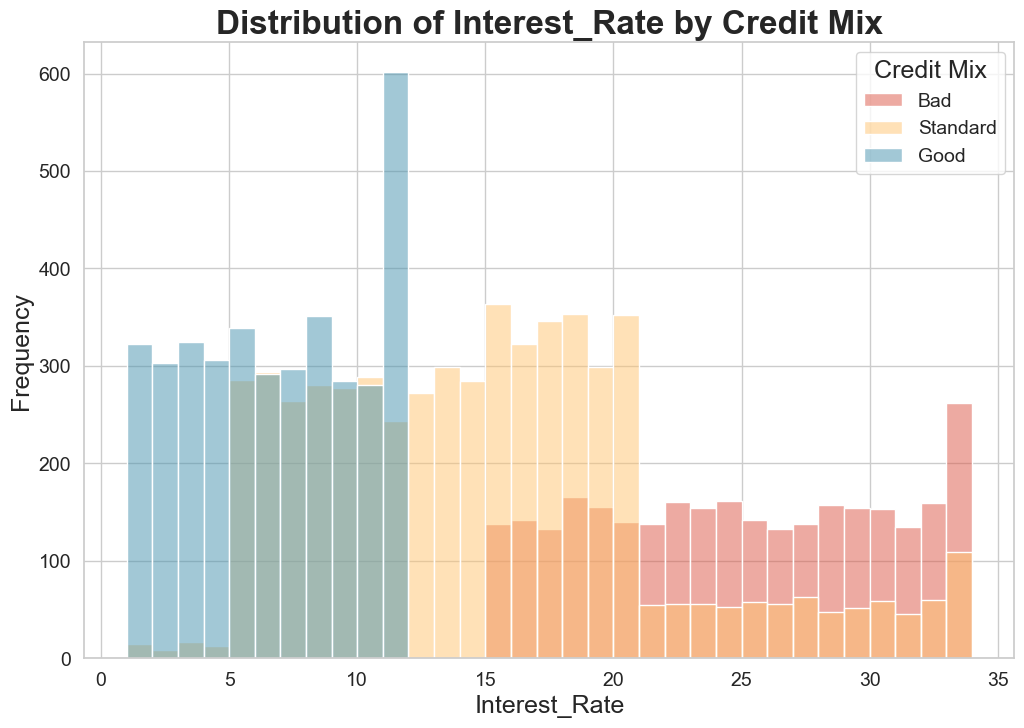

In [290]:
plt.figure(figsize=(12, 8))
###############################################################################
# Credit_Mix 별로 분포 그리기
credit_mix_categories = df_grouped['Credit_Mix'].unique()
colors = {'Bad': '#DD5746', 'Standard': '#FFC470', 'Good': '#4793AF'}

for credit_mix in credit_mix_categories:
    sns.histplot(
        df_grouped[df_grouped['Credit_Mix'] == credit_mix]['Interest_Rate'], 
        label=credit_mix, 
        color=colors[credit_mix], 
        binwidth=1, 
        kde=False, 
        alpha=0.5
    )

# 폰트 크기 설정 (1.5배)
plt.title('Distribution of Interest_Rate by Credit Mix', fontsize=24, weight='bold')
plt.xlabel('Interest_Rate', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 범례 추가
plt.legend(title='Credit Mix', title_fontsize=18, fontsize=14)

# 그래프 표시
plt.show()

### 4-2-5. Num Bank Account

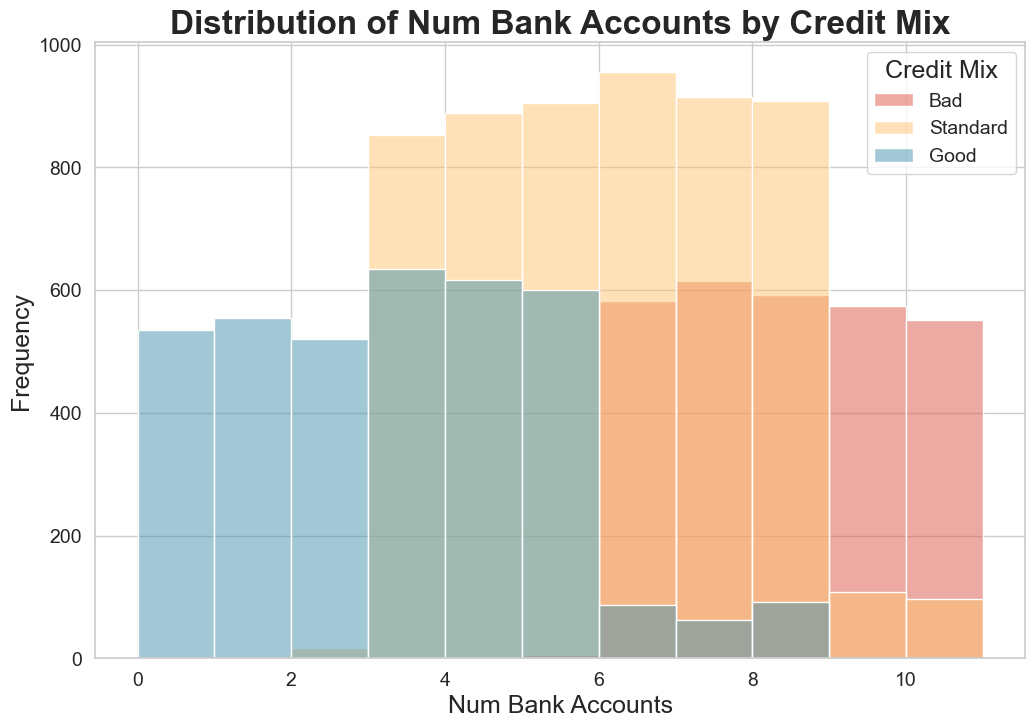

In [282]:
# 'Num_Bank_Accounts'에 대한 히스토그램 생성
plt.figure(figsize=(12, 8))

# Credit_Mix 별로 분포 그리기
credit_mix_categories = df_grouped['Credit_Mix'].unique()
colors = {'Bad': '#DD5746', 'Standard': '#FFC470', 'Good': '#4793AF'}

for credit_mix in credit_mix_categories:
    sns.histplot(
        df_grouped[df_grouped['Credit_Mix'] == credit_mix]['Num_Bank_Accounts'], 
        label=credit_mix, 
        color=colors[credit_mix], 
        binwidth=1, 
        kde=False, 
        alpha=0.5
    )

# 폰트 크기 설정 (1.5배)
plt.title('Distribution of Num Bank Accounts by Credit Mix', fontsize=24, weight='bold')
plt.xlabel('Num Bank Accounts', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 범례 추가
plt.legend(title='Credit Mix', title_fontsize=18, fontsize=14)

# 그래프 표시
plt.show()

### Delay from due date (마감지연일)

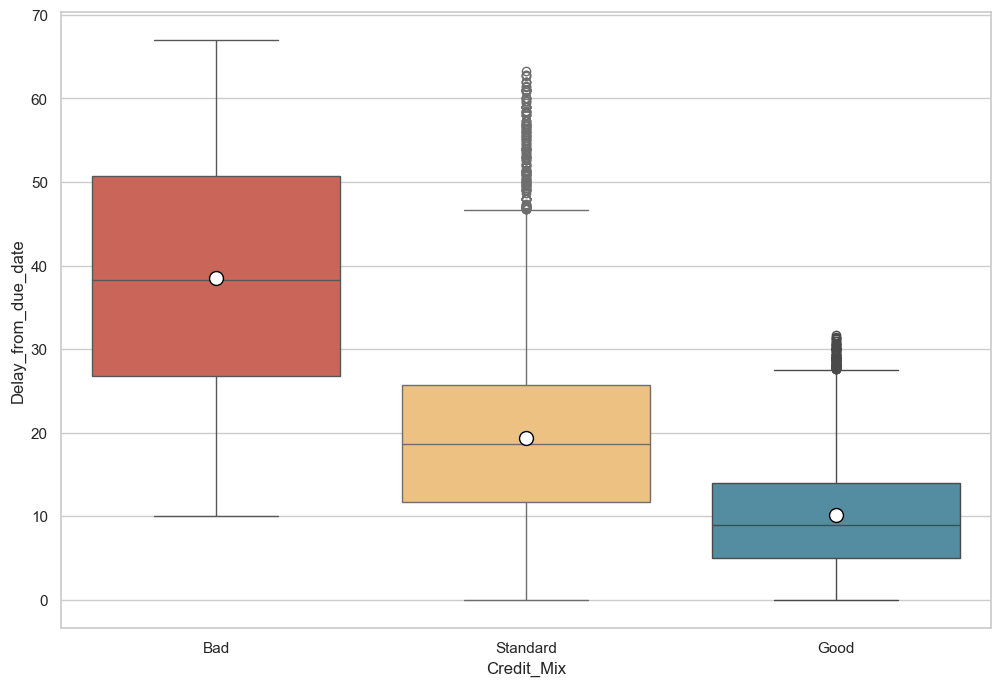

In [302]:
# Credit mix 별로 Delay from due date 시각화   (박스 플롯) 최대한 이쁘게
plt.figure(figsize=(12, 8))

# Credit_Mix 별로 분포 그리기
credit_mix_categories = df_grouped['Credit_Mix'].unique()
colors = {'Bad': '#DD5746', 'Standard': '#FFC470', 'Good': '#4793AF'}

for credit_mix in credit_mix_categories: 
    sns.boxplot(
        x='Credit_Mix', 
        y='Delay_from_due_date', 
        data=df_grouped[df_grouped['Credit_Mix'] == credit_mix], 
        color=colors[credit_mix], 
        showmeans=True, 
        meanprops={"marker":"o",
                        "markerfacecolor":"white", 
                        "markeredgecolor":"black",
                        "markersize":"10"}
    )


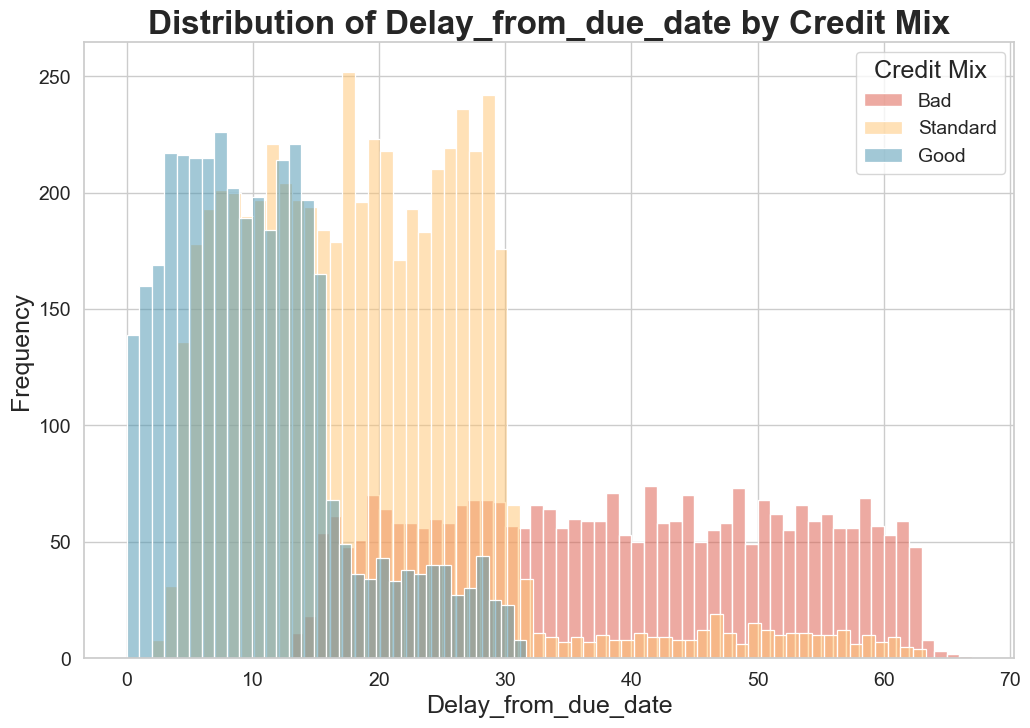

In [301]:
# 'Num_Bank_Accounts'에 대한 히스토그램 생성
plt.figure(figsize=(12, 8))

# Credit_Mix 별로 분포 그리기
credit_mix_categories = df_grouped['Credit_Mix'].unique()
colors = {'Bad': '#DD5746', 'Standard': '#FFC470', 'Good': '#4793AF'}

for credit_mix in credit_mix_categories:
    sns.histplot(
        df_grouped[df_grouped['Credit_Mix'] == credit_mix]['Delay_from_due_date'], 
        label=credit_mix, 
        color=colors[credit_mix], 
        binwidth=1, 
        kde=False, 
        alpha=0.5
    )

# 폰트 크기 설정 (1.5배)
plt.title('Distribution of Delay_from_due_date by Credit Mix', fontsize=24, weight='bold')
plt.xlabel('Delay_from_due_date', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 범례 추가
plt.legend(title='Credit Mix', title_fontsize=18, fontsize=14)

# 그래프 표시
plt.show()

## 4-3. Bad Customers Deep Dive

In [196]:
# class_mix 변수가 bad 인 고객 
bad_customers = df_grouped[df_grouped['Credit_Mix'] == 'Bad']    
print("신용 등급이 나쁜 고객 수 :", bad_customers.shape[0])

## 데이터 저장
# bad_customers.to_csv(r'.\data\Bad_Customers.csv', index=False)

신용 등급이 나쁜 고객 수 : 2919


In [197]:
print("30일 이상 (요주의 고객) :", np.round(bad_customers[bad_customers['Delay_from_due_date'] > 30].shape[0] / bad_customers.shape[0], 2), "%")

30일 이상 (요주의 고객) : 0.67 %


### 4-3-1. 요주의 고객 확인!

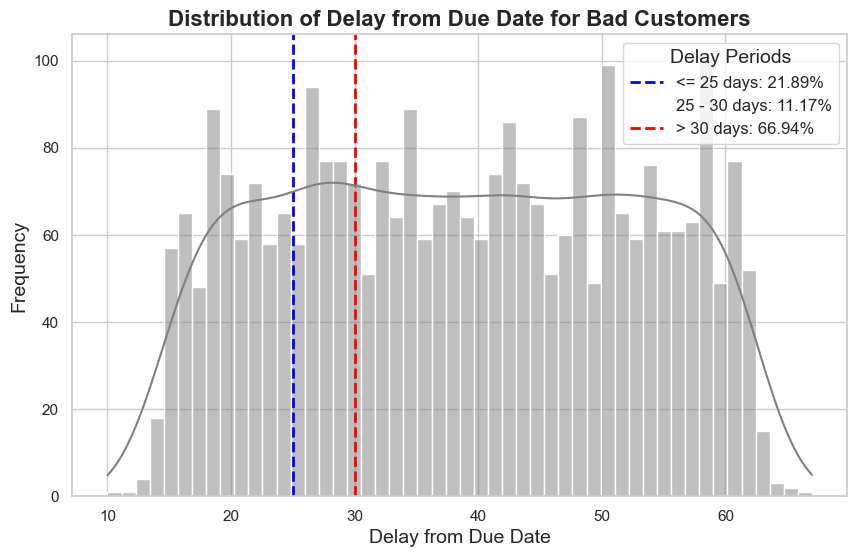

In [243]:
# Delay_from_due_date 분포 시각화
plt.figure(figsize=(10, 6))

# 25일 및 30일에 수직선 추가
plt.axvline(25, color='blue', linestyle='--', linewidth=2, label='25 days')
plt.axvline(30, color='red', linestyle='--', linewidth=2, label='30 days')

# 히스토그램 및 KDE 플롯
sns.histplot(bad_customers['Delay_from_due_date'], bins=50, kde=True, color='grey')

# 각 구간별 비율 계산
total_count = len(bad_customers['Delay_from_due_date'])
below_25 = len(bad_customers[bad_customers['Delay_from_due_date'] <= 25]) / total_count * 100
between_25_30 = len(bad_customers[(bad_customers['Delay_from_due_date'] > 25) & (bad_customers['Delay_from_due_date'] <= 30)]) / total_count * 100
above_30 = len(bad_customers[bad_customers['Delay_from_due_date'] > 30]) / total_count * 100

# 범례 설정
labels = [
    f'<= 25 days: {below_25:.2f}%',
    f'25 - 30 days: {between_25_30:.2f}%',
    f'> 30 days: {above_30:.2f}%'
]
handles = [
    plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=2),
    plt.Line2D([0], [0], color='black', linestyle=''),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2)
]
plt.legend(handles, labels, loc='upper right', fontsize=12, title='Delay Periods', title_fontsize='14')

# 제목 및 라벨 설정
plt.title('Distribution of Delay from Due Date for Bad Customers', fontsize=16, weight='bold')
plt.xlabel('Delay from Due Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# 그래프 표시
plt.show()

### 4-3-2. PCA + Kmeans Clustering
- 주성분 분석으로 2 개의 축을 생성하고 PCA1, PCA2 를 활용해 Kmeans Clustering 후 분석

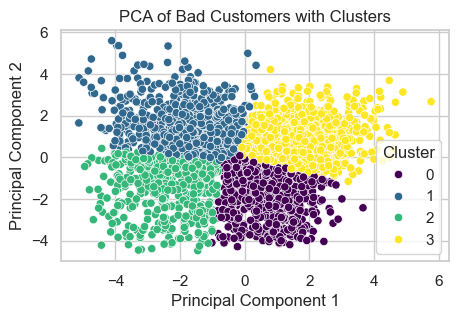

In [199]:
# bad_customers 에 대해서 주성분 분석으로 주성분 2개를 추출하고 이를 통해서 kmeans clustering을 수행
# 필요한 범주형 변수 선택
categorical_vars = ['Payment_of_Min_Amount', 'Payment_Behaviour', 'Age_group']

# 범주형 변수를 원-핫 인코딩
df_encoded = pd.get_dummies(bad_customers, columns=categorical_vars)

# 모든 변수 선택 (연속형 변수 + 원-핫 인코딩된 범주형 변수)
features = df_encoded.columns.difference(['Customer_ID', 'Credit_Mix', 'Occupation'])

# 데이터 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded[features])

# PCA 수행
pca = PCA(n_components=2, random_state=42)  # 2개의 주성분으로 축소
pca_result = pca.fit_transform(scaled_features)

# 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
# pca_df['Credit_Mix'] = df_grouped['Credit_Mix']

# kmeans clustering
from sklearn.cluster import KMeans

# kmeans 모델 생성
kmeans = KMeans(n_clusters=4, random_state=42)

# kmeans 모델 훈련
kmeans.fit(pca_result)

# 클러스터 할당
clusters = kmeans.predict(pca_result)

# 클러스터 할당 결과를 데이터프레임에 추가
pca_df['Cluster'] = clusters
bad_customers['Cluster'] = clusters

plt.figure(figsize=(5, 3))
sns.scatterplot(x='PC1', y='PC2',hue = 'Cluster', data=pca_df, palette='viridis')
# kmeans 와 pca 
plt.title('PCA of Bad Customers with Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [150]:
print(bad_customers.groupby('Cluster').size())

continuous_vars = [
    'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 
    'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 
    'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 
    'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 
    'Monthly_Balance', 'Age', 'Credit_History_Age', 'Cluster'
]

# bad_customers[continuous_vars].groupby('Cluster').mean().to_csv(r".\data\Bad_Customers_Clustered.csv")

# cluster 별 age_group 비율
age_group_cross = pd.crosstab(bad_customers['Cluster'], bad_customers['Age_group'])
age_group_cross

Cluster
0    1160
1     384
2     663
3     712
dtype: int64


Age_group  10s  20s  30s  40s  over 60s
Cluster                                
0          211  347  438  164         0
1           77  115  107   85         0
2          125  227  169  142         0
3          152  215  231  113         1

In [151]:
# cluster 별 대출 상품 종류 비율 'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'None', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan'
bad_customers[['Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'None', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan', 'Age_group','Cluster']].groupby(['Cluster', 'Age_group']).agg('sum')
bad_customers[['Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'None', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan', 'Cluster']].groupby(['Cluster']).agg('sum') / bad_customers.groupby('Cluster').size().values.reshape(-1, 1)

Auto Loan  Credit-Builder Loan  Debt Consolidation Loan  \
Cluster                                                            
0         0.575000             0.585345                 0.569828   
1         0.395833             0.380208                 0.395833   
2         0.386124             0.435897                 0.404223   
3         0.554775             0.605337                 0.536517   

         Home Equity Loan  Mortgage Loan  None  Not Specified  Payday Loan  \
Cluster                                                                      
0                0.589655       0.575000   0.0       0.557759     0.584483   
1                0.408854       0.406250   0.0       0.432292     0.401042   
2                0.374057       0.416290   0.0       0.390649     0.434389   
3                0.595506       0.589888   0.0       0.571629     0.567416   

         Personal Loan  Student Loan  
Cluster                               
0             0.570690      0.555172  
1             0.385417      0.398438  
2             0.408748      0.398190  
3             0.568820      0.578652

In [152]:
age_group_cross = pd.crosstab(bad_customers['Cluster'], bad_customers['Occupation'])
np.round(age_group_cross / age_group_cross.sum(axis=1).values.reshape(-1, 1), 2)

Occupation  Accountant  Architect  Developer  Doctor  Engineer  Entrepreneur  \
Cluster                                                                        
0                 0.07       0.07       0.06    0.07      0.06          0.06   
1                 0.08       0.07       0.07    0.06      0.11          0.09   
2                 0.05       0.05       0.07    0.07      0.08          0.07   
3                 0.07       0.06       0.08    0.07      0.07          0.06   

Occupation  Journalist  Lawyer  Manager  Mechanic  Media_Manager  Musician  \
Cluster                                                                      
0                 0.06    0.06     0.07      0.08           0.07      0.07   
1                 0.08    0.06     0.03      0.07           0.04      0.06   
2                 0.06    0.09     0.07      0.06           0.05      0.05   
3                 0.06    0.06     0.08      0.08           0.06      0.06   

Occupation  Scientist  Teacher  Writer  unemployment  
Cluster                                               
0                0.06     0.08    0.06           0.0  
1                0.06     0.06    0.06           0.0  
2                0.09     0.08    0.06           0.0  
3                0.07     0.05    0.06           0.0

In [246]:
# 각 고객의 비중 
bad_customers['Cluster'].value_counts() / df_grouped.shape[0]

Cluster
3    0.084794
1    0.057970
0    0.057888
2    0.037342
Name: count, dtype: float64

### 4-3-3. Customizable 한 기준을 세워서 초 고위험군 도출 ? 

In [66]:
# 주요 지표들 선정
key_indicators = ['Outstanding_Debt', 'Total_EMI_per_month', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Amount_invested_monthly', 'Credit_Utilization_Ratio', 'Num_Credit_Inquiries']
key_indicators = ['Delay_from_due_date', 'Num_of_Delayed_Payment', 'Interest_Rate']

# 각 지표에 대한 상위 10% 고객들을 선정
# 선정한 지표들 중 하나 이상 만족하는 고객을 선정
top_10_percent_customers = bad_customers[bad_customers[key_indicators].apply(lambda x: (x >= x.quantile(0.90)), axis=0).all(axis=1)]

# 결과 출력
top_10_percent_customers.shape

(6, 33)

In [111]:
bad_customers[bad_customers['Customer_ID'] == 'CUS_0x7720']

Customer_ID Occupation  Annual_Income  Monthly_Inhand_Salary Credit_Mix  \
6755  CUS_0x7720  Scientist       33426.96                2533.58        Bad   

     Payment_of_Min_Amount                Payment_Behaviour  \
6755                   Yes  Low_spent_Medium_value_payments   

      Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
6755               10.0              6.0           34.0          7.0   

      Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  \
6755                 58.5                    26.5                  1.79   

      Num_Credit_Inquiries  Outstanding_Debt  Credit_Utilization_Ratio  \
6755                  10.0            1432.3                 34.845207   

      Total_EMI_per_month  Amount_invested_monthly  Monthly_Balance   Age  \
6755           187.191253               261.457024        89.709723  20.0   

      Credit_History_Age  Auto Loan  Credit-Builder Loan  \
6755                  18          0                    1   

      Debt Consolidation Loan  Home Equity Loan  Mortgage Loan  None  \
6755                        1                 0              1     0   

      Not Specified  Payday Loan  Personal Loan  Student Loan Age_group  \
6755              1            1              0             0       10s   

      Cluster  
6755        3

In [98]:
list(top_10_percent_customers.Customer_ID.values)

# 3, 3, 3, 1, 2, 1

['CUS_0x1145',
 'CUS_0x51b4',
 'CUS_0x7720',
 'CUS_0x7a6c',
 'CUS_0x95c9',
 'CUS_0xa614']

In [67]:
top_10_percent_customers

Customer_ID Occupation  Annual_Income  Monthly_Inhand_Salary Credit_Mix  \
74    CUS_0x1145    Teacher       17975.32            1444.943333        Bad   
4248  CUS_0x51b4   Engineer       17655.43            1530.285833        Bad   
6755  CUS_0x7720  Scientist       33426.96            2533.580000        Bad   
6974  CUS_0x7a6c     Writer       29265.30            2410.775000        Bad   
8786  CUS_0x95c9   Mechanic       59612.64            5067.720000        Bad   
9862  CUS_0xa614  Scientist       18184.99            1336.415833        Bad   

     Payment_of_Min_Amount                 Payment_Behaviour  \
74                     Yes   Low_spent_Medium_value_payments   
4248                   Yes    Low_spent_Small_value_payments   
6755                   Yes   Low_spent_Medium_value_payments   
6974                   Yes    Low_spent_Small_value_payments   
8786                   Yes  High_spent_Medium_value_payments   
9862                   Yes    Low_spent_Small_value_payments   

      Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
74                  6.0              5.0           32.0          9.0   
4248                8.0             10.0           34.0          6.0   
6755               10.0              6.0           34.0          7.0   
6974                9.0              9.0           34.0          6.0   
8786                6.0              5.0           32.0          7.0   
9862                7.0              6.0           34.0          6.0   

      Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  \
74                  61.00               25.666667              7.566667   
4248                58.75               24.500000             27.490000   
6755                58.50               26.500000              1.790000   
6974                62.25               25.500000              7.650000   
8786                59.75               25.750000             19.680000   
9862                61.00               25.000000              9.740000   

      Num_Credit_Inquiries  Outstanding_Debt  Credit_Utilization_Ratio  \
74                   13.00           1263.10                 29.707083   
4248                 10.75           2725.14                 29.016905   
6755                 10.00           1432.30                 34.845207   
6974                 10.75           1465.62                 33.047227   
8786                 12.00           4764.40                 26.813104   
9862                  9.00           1494.99                 35.758456   

      Total_EMI_per_month  Amount_invested_monthly  Monthly_Balance   Age  \
74              76.450325               114.155238       237.222104  24.0   
4248            82.654219                98.245871       247.128494  36.0   
6755           187.191253               261.457024        89.709723  20.0   
6974           120.122743               206.980630       191.474128  32.0   
8786           283.733432               116.166434       311.320247  40.0   
9862            88.561595                93.944011       233.635978  28.0   

      Credit_History_Age  Auto Loan  Credit-Builder Loan  \
74                    12          0                    1   
4248                   9          1                    1   
6755                  18          0                    1   
6974                  20          1                    0   
8786                   3          1                    1   
9862                  16          0                    1   

      Debt Consolidation Loan  Home Equity Loan  Mortgage Loan  None  \
74                          0                 1              1     0   
4248                        1                 1              0     0   
6755                        1                 0              1     0   
6974                        0                 1              1     0   
8786                        0                 0              1     0   
9862                        0                 0     

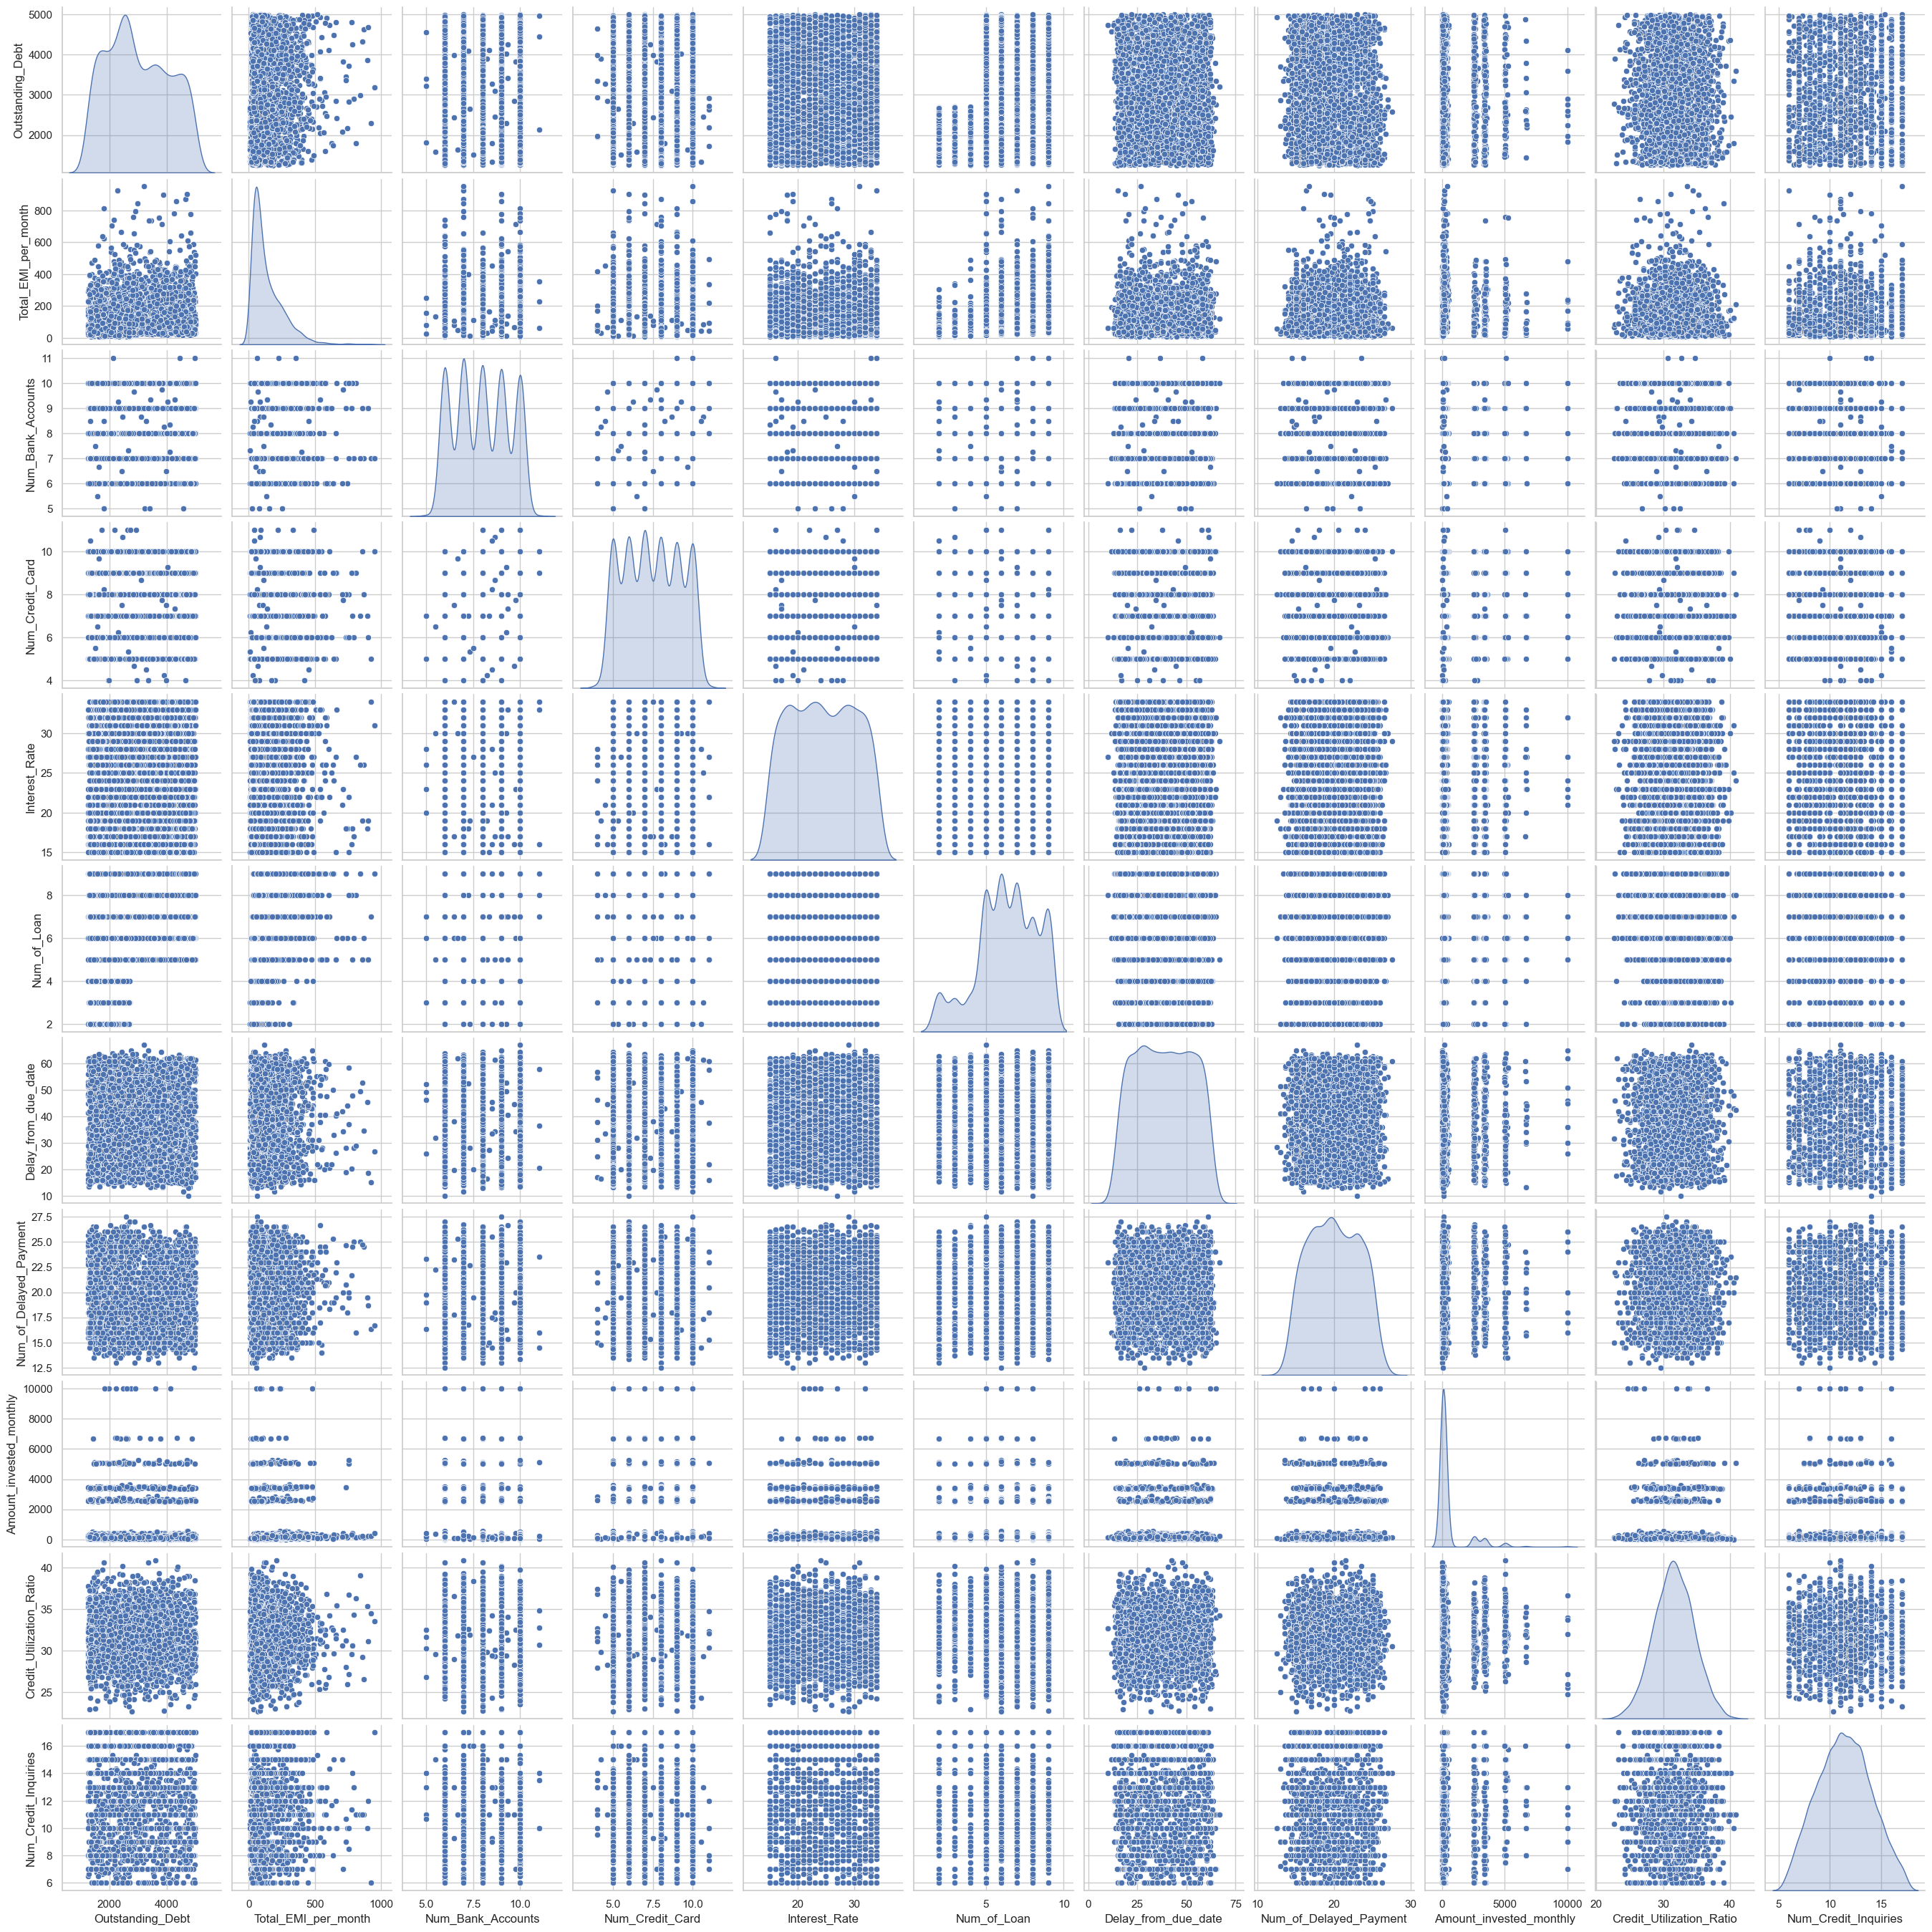

In [62]:
key_indicators = ['Outstanding_Debt', 'Total_EMI_per_month', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Amount_invested_monthly', 'Credit_Utilization_Ratio', 'Num_Credit_Inquiries']

# 각 변수들간의 산점도를 모두 그리고 싶음 
# seaborn pairplot 사용
sns.pairplot(bad_customers[key_indicators], diag_kind='kde', kind='scatter', palette='pastel')
plt.show()